In [2]:
# Some Preliminary imports and so on
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits
import pyana

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# Open the inverted Stokes file and grab the data

stokes = pyana.fzread("/home/milic/data/MiHi/snapi_inv/mihi_630_sf_cgs_obs.f0")["data"]
stokes.shape

(61, 61, 4, 200)

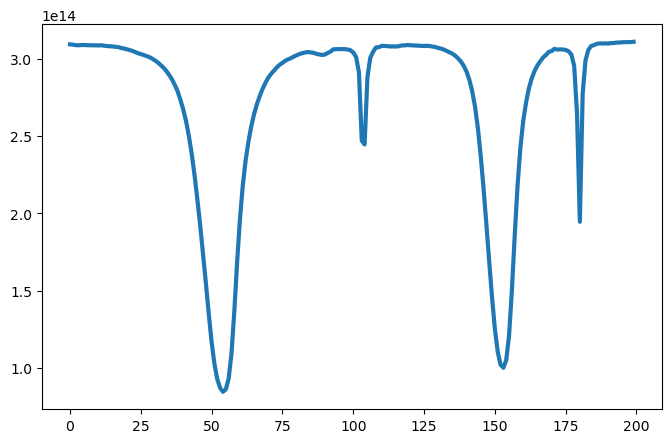

In [4]:
# Find the mean spectrum
mean_spectrum = np.mean(stokes, axis=(0,1))

plt.figure(figsize=[8,5])
plt.plot(mean_spectrum[0], linewidth=3)
#plt.xlim([5,30])

In [5]:
qs = np.amax(mean_spectrum)
print(qs)

310988717940189.25


In [6]:
stokes = stokes/qs

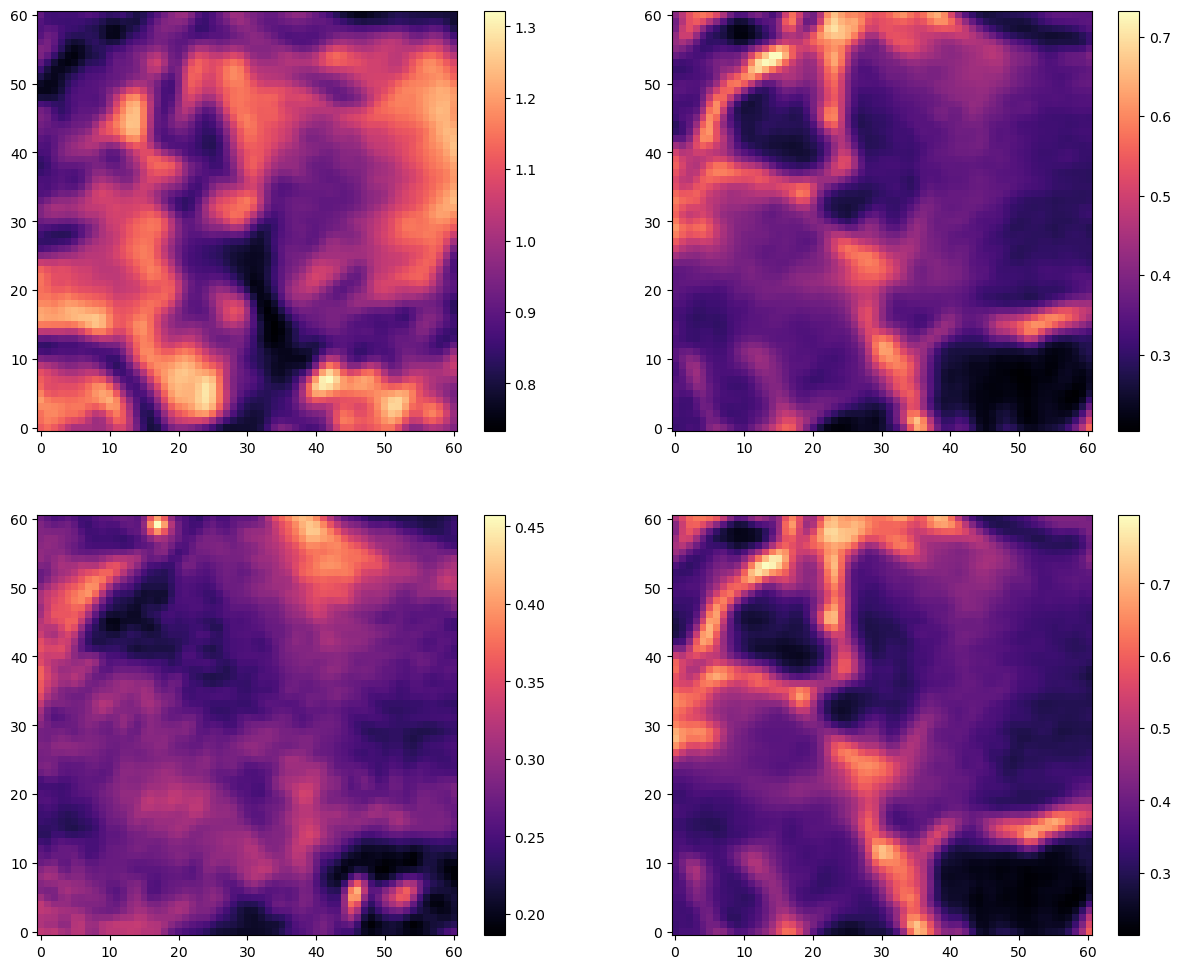

In [7]:
plt.figure(figsize=[15,12])
plt.subplot(221)
plt.imshow(stokes[:,:,0,0].T,cmap='magma',origin='lower')
plt.colorbar()
plt.subplot(222)
plt.imshow(stokes[:,:,0,50].T,cmap='magma',origin='lower')
plt.colorbar()
plt.subplot(223)
plt.imshow(stokes[:,:,0,55].T,cmap='magma',origin='lower')
plt.colorbar()
plt.subplot(224)
plt.imshow(stokes[:,:,0,150].T,cmap='magma',origin='lower')
plt.colorbar()

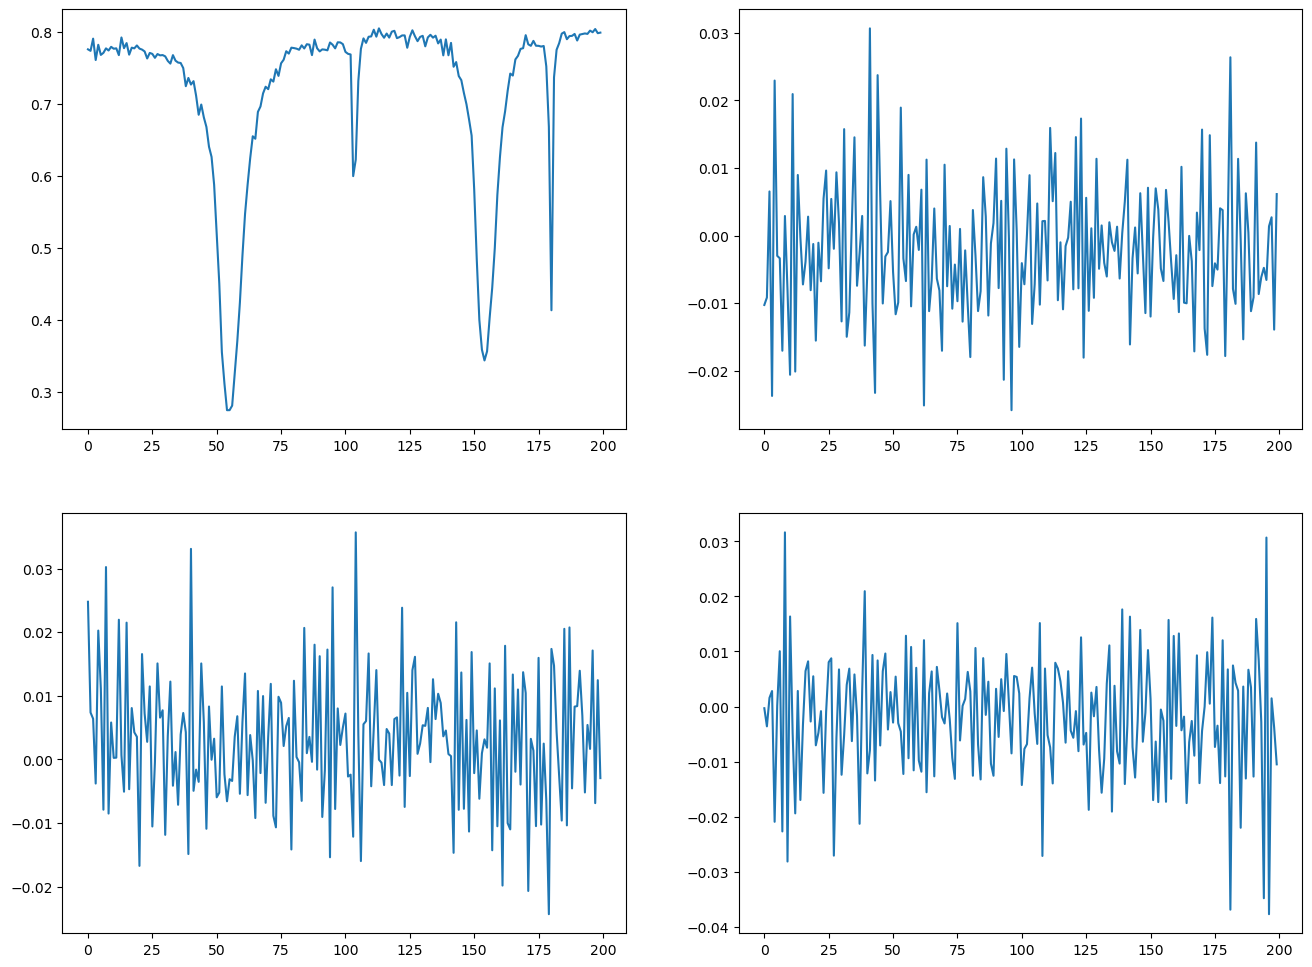

In [8]:
plt.figure(figsize=[16,12])
i = 30
j = 25

plt.subplot(221)
plt.plot(stokes[i,j,0])

plt.subplot(222)
plt.plot(stokes[i,j,1])

plt.subplot(223)
plt.plot(stokes[i,j,2])

plt.subplot(224)
plt.plot(stokes[i,j,3])


In [9]:
# Cut the data for the training: 

training = stokes[:,:,[0,3],:]
training.shape

(61, 61, 2, 200)

# Preparing the data for the NN training

### We are now going to do something fairly straightforward and technical. Normalize the spectra (input) and the temperature and velocity at few fixed heights (output), to the range 0,1 and write it to separate .fits files, so that we can train a network .

### With the little bit more advanced neural network architectures (that you probably know better than me), you can probably automatize this. 

### Also, batch normalization should (I think) get rid of many of these things for you automatically

In [ ]:
### We will also make sure we save the normalizing quantities to the fits file so that we transform the outputs to the meaningful physical quantities.
### Very simple: 

In [10]:
tmean = np.mean(training[:,:,0,:])
tstd = np.std(training[:,:,0,:])

training_norm = training[:,:,:] / tstd
training_norm[:,:,0,:] -= tmean / tstd
                 
training_norm [:,:,1,:] *= 2.0


training_norm = training_norm.reshape(-1,2*len(training_norm[0,0,0]))

In [13]:
print(tmean, tstd)

0.8788716484966074 0.22391241342834492


In [11]:
training_norm.shape

(3721, 400)

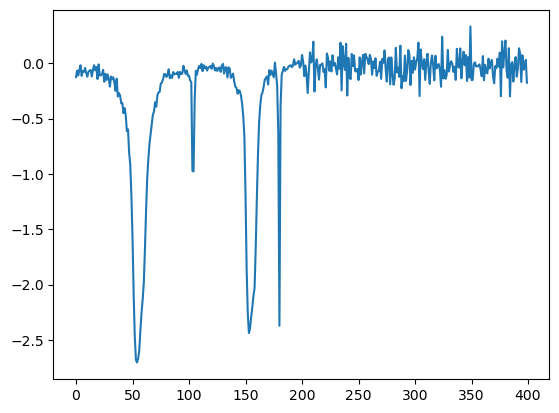

In [12]:
plt.plot(training_norm[333])

In [1]:
training_norm = training_norm.astype("float32")

NameError: name 'training_norm' is not defined

In [24]:
datahdu = fits.PrimaryHDU(training_norm)
normhdu = fits.ImageHDU([tmean, tstd])

In [25]:
hdulist = fits.HDUList([datahdu, normhdu])
hdulist.writeto("normalized_data_in.fits",overwrite=True)

In [26]:
# Now the inversion results 

inv_data = pyana.fzread("/home/milic/data/MiHi/snapi_inv/inverted_nodes.f0")["data"]

In [27]:
inv_data.shape

(10, 61, 61)

In [28]:
inv_data = inv_data.transpose(0,2,1)

In [29]:
atmos = pyana.fzread("/home/milic/data/MiHi/snapi_inv/inverted_atmos.f0")["data"]

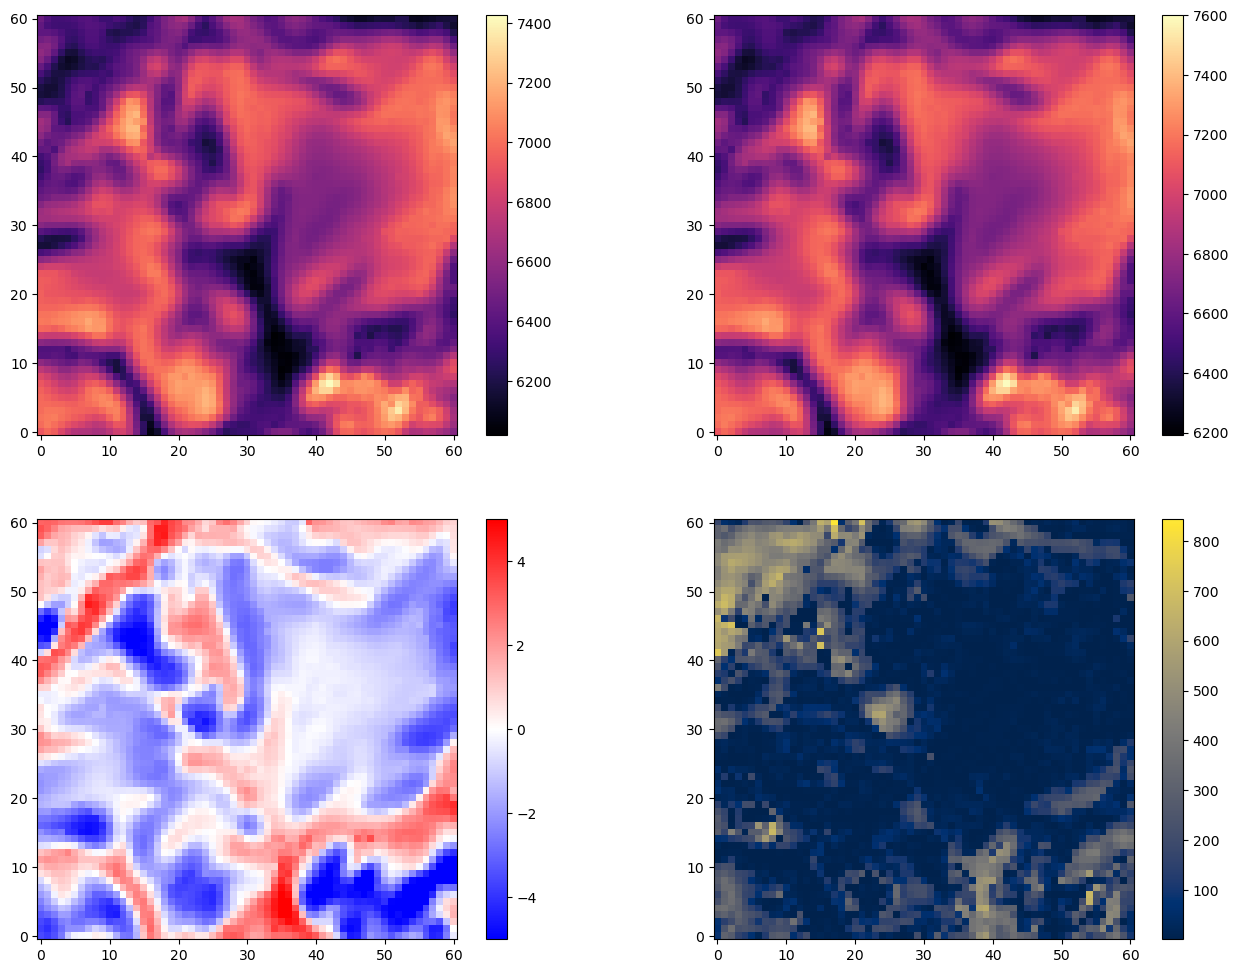

In [31]:
plt.figure(figsize=[16,12])

plt.subplot(221)
plt.imshow(inv_data[4].T,cmap='magma',origin='lower')
plt.colorbar()

plt.subplot(222)
plt.imshow(atmos[2,:,:,-10].T,cmap='magma',origin='lower')
plt.colorbar()

plt.subplot(223)
plt.imshow(inv_data[7].T/-1E5,cmap='bwr',vmin=-5,vmax=5,origin='lower')
plt.colorbar()

plt.subplot(224)
plt.imshow(inv_data[8].T,cmap='cividis',origin='lower')
plt.colorbar()

In [32]:
T_mean = np.mean(inv_data[0:5])
T_std = np.std(inv_data[0:5])
v_mean = np.mean(inv_data[5:8])
v_std = np.std(inv_data[5:8])

B_mean = np.mean(inv_data[8])
B_std = np.std(inv_data[8])
mu = np.cos(inv_data[9])

In [33]:
inv_data_norm = np.copy(inv_data)
inv_data_norm[:,:,:] = 0.0
inv_data_norm[0:5] = (inv_data[0:5] - T_mean) / T_std
inv_data_norm[5:8] = (inv_data[5:8] - v_mean) / v_std
inv_data_norm[8] = (inv_data[8] - B_mean) / B_std

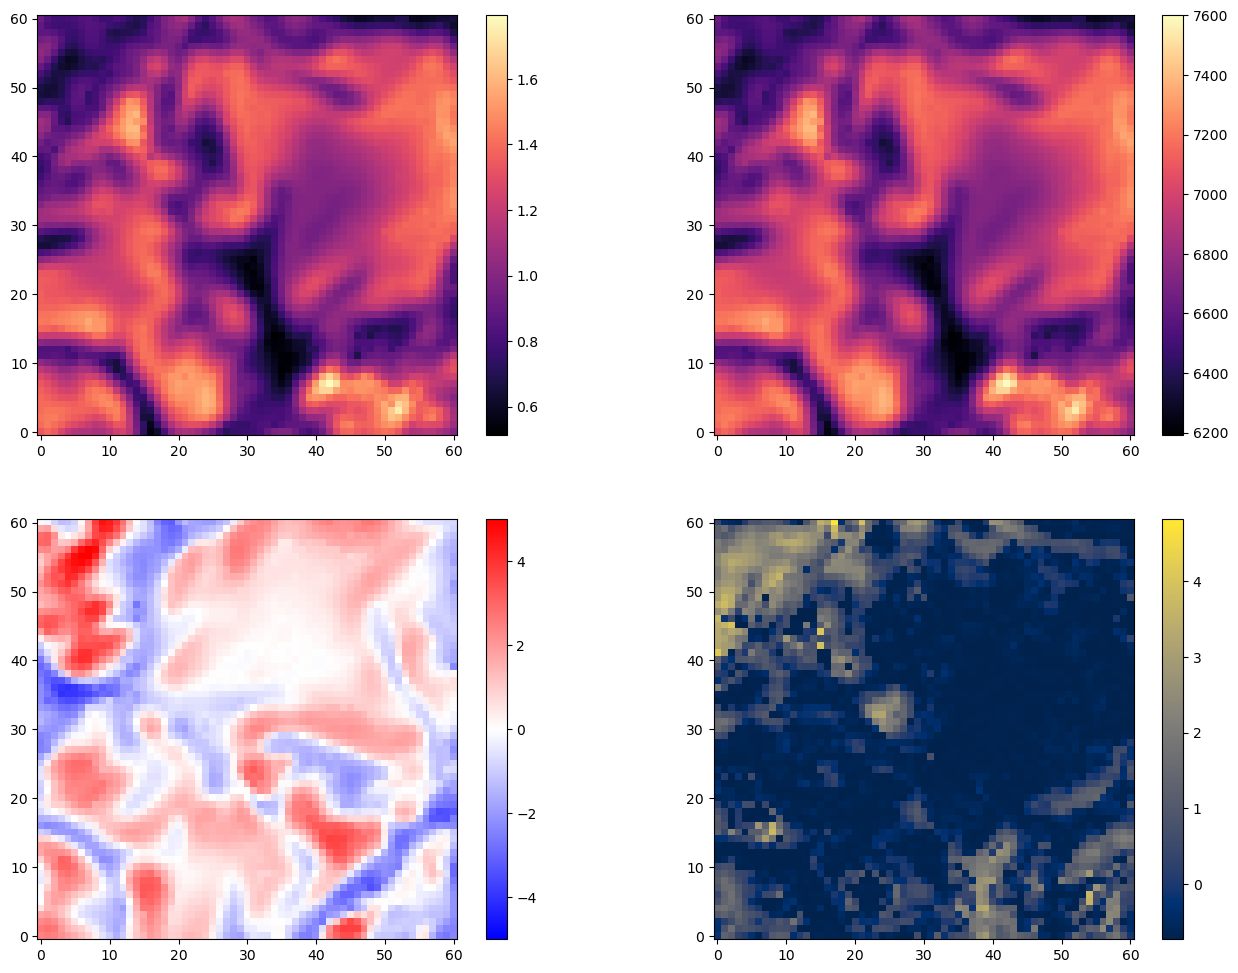

In [34]:
plt.figure(figsize=[16,12])

plt.subplot(221)
plt.imshow(inv_data_norm[4].T,cmap='magma',origin='lower')
plt.colorbar()

plt.subplot(222)
plt.imshow(atmos[2,:,:,-10].T,cmap='magma',origin='lower')
plt.colorbar()

plt.subplot(223)
plt.imshow(inv_data_norm[7],cmap='bwr',vmin=-5,vmax=5,origin='lower')
plt.colorbar()

plt.subplot(224)
plt.imshow(inv_data_norm[8].T,cmap='cividis',origin='lower')
plt.colorbar()

In [35]:
hdu1 = fits.PrimaryHDU(inv_data_norm)
hdu2 = fits.ImageHDU([T_mean, T_std])
hdu3 = fits.ImageHDU([v_mean, v_std])
hdu4 = fits.ImageHDU([B_mean, B_std])

In [36]:
hdulist = fits.HDUList([hdu1, hdu2, hdu3, hdu4])
hdulist.writeto("normalized_data_out.fits",overwrite=True)

## Time to go to training! -> Lunch